In [2]:
# importing libraries
import pandas as pd
from datasets import Dataset, load_dataset, load_from_disk, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments,Trainer
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Reading the csv file
X = pd.read_csv('table_to_train_the_model.csv')

In [4]:
# Converting pandas dataframe into a dataset
dataset = Dataset.from_pandas(X, preserve_index=False)

In [5]:
# Splitting the data into train and test
dataset = dataset.train_test_split(test_size=0.3)
raw_train_ds = dataset["train"]  # Training dataset
remaining_data = dataset["test"]

In [6]:
# Get the validation dataset testing dataset
dataset_2 = remaining_data.train_test_split(test_size=0.5)
raw_test_ds = dataset_2["train"]  # Testing dataset
raw_val_ds = dataset_2["test"]  # Validation dataset

In [7]:
# Print the description of the train_ds
raw_train_ds, raw_val_ds, raw_test_ds

(Dataset({
     features: ['RelatedLesson', 'no_of_occurance'],
     num_rows: 692
 }),
 Dataset({
     features: ['RelatedLesson', 'no_of_occurance'],
     num_rows: 149
 }),
 Dataset({
     features: ['RelatedLesson', 'no_of_occurance'],
     num_rows: 148
 }))

In [8]:
# Output of one row in the dataset
raw_train_ds[0]

{'RelatedLesson': 'data representation', 'no_of_occurance': 2}

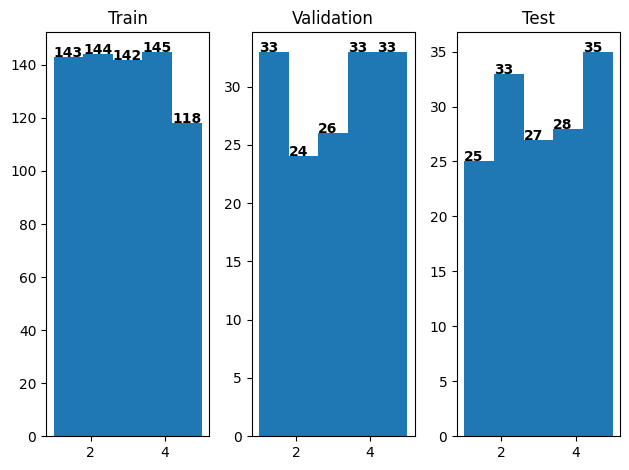

In [9]:
# analysing the class (no_of_occurrence) distribution in each dataset.
fig, axs = plt.subplots(1, 3, tight_layout=True)
distributions = []

axs[0].set_title("Train")
axs[1].set_title("Validation")
axs[2].set_title("Test")

train_distributions = axs[0].hist(raw_train_ds["no_of_occurance"], bins=5)
val_distributions = axs[1].hist(raw_val_ds["no_of_occurance"], bins=5)
test_distributions = axs[2].hist(raw_test_ds["no_of_occurance"], bins=5)

for distributions, ax in zip([train_distributions, val_distributions, test_distributions], axs):
    for j in range(5):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")

In [10]:
# Load the model and the tokenizer
BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

# Let's name the classes 1, 2, 3, 4, 5 like their indices
id2label = {k: k for k in range(0, 6)}
label2id = {k: k for k in range(0, 6)}

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

In [11]:
# Tokenize the dataset and associate the label attribute to each dataset item
ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}


def preprocess_function(examples):
    label = examples["no_of_occurance"]
    examples = tokenizer(examples["RelatedLesson"], truncation=True, padding="max_length", max_length=256)
    examples["label"] = label
    return examples


for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["RelatedLesson", "no_of_occurance"])

  0%|          | 0/692 [00:00<?, ?ex/s]

  0%|          | 0/149 [00:00<?, ?ex/s]

  0%|          | 0/148 [00:00<?, ?ex/s]

In [12]:
# Creating a function to calculate the global accuracy score
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

E:\Apps\Python\Python Interpreters\Python 3.7\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


In [ ]:
# Training the model

training_args = TrainingArguments(
    output_dir="../Model Training/camembert-fine-tuned-regression",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics
)

trainer.train()